# Explanatory Deep Learning
Two different methods are studied on MNIST dataset to find important feature in image for deep learning classification. Further details inside following references.

1. Masking [ref](https://arxiv.org/pdf/1911.06876.pdf) 
2. Saliancy Map [ref](https://arxiv.org/abs/1610.02391) 

**future work: CNN and Graph Neural Network**<br> 
*additional documentations in the future*

In [37]:
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers 
import matplotlib.pyplot as plt


model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [40]:
original_dim = 784

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype("float32")  / 255
x_test = x_test.reshape(x_test.shape[0], 784).astype("float32") 


In [3]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [4]:
model.fit(x_train, y_train, epochs=40)

Epoch 1/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3741 - accuracy: 0.8925
Epoch 2/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1019 - accuracy: 0.9687
Epoch 3/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0605 - accuracy: 0.9812
Epoch 4/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0424 - accuracy: 0.9871
Epoch 5/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0296 - accuracy: 0.9908
Epoch 6/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0237 - accuracy: 0.9931
Epoch 7/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0163 - accuracy: 0.9950
Epoch 8/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0131 - accuracy: 0.9964
Epoch 9/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0106 - accuracy: 0.9965
Epoch 10/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.010

In [5]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 33.1153 - accuracy: 0.9835

Test accuracy: 0.9835000038146973


In [41]:
# model.get_config()

In [7]:
layer_output = model.get_layer('dense').output
layer_output.trainable =False
model.trainable = False
explainer_layer1 = Dense(int(original_dim/2), activation='relu')(layer_output)#
mask = Dense(original_dim, activation='sigmoid',activity_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.0001))(explainer_layer1)#
new_input = tf.keras.layers.Multiply()([mask, model.input])
class_new = model(new_input, training=False)
model2 = Model(model.input, outputs=class_new)


In [8]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model2.fit(x_train, y_train, epochs=30)

Epoch 1/30
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0404 - accuracy: 0.9941
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0188 - accuracy: 0.9984
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0154 - accuracy: 0.9984
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0139 - accuracy: 0.9982
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0104 - accuracy: 0.9986
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0083 - accuracy: 0.9990
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0071 - accuracy: 0.9994
Epoch 8/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0069 - accuracy: 0.9990
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0057 - accuracy: 0.9993
Epoch 10/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.005

In [10]:
test_loss, test_acc = model2.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 32.6849 - accuracy: 0.9812

Test accuracy: 0.9811999797821045


In [42]:
# model2.get_config()

In [12]:
layer_output = model2.get_layer('multiply').output
modelexplainer = Model(model2.input, outputs=layer_output)

In [13]:
model.summary(), model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 0
Non-trainable params: 203,530
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_input (InputLayer)        [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      dense_input[0][0]                
__

(None, None)

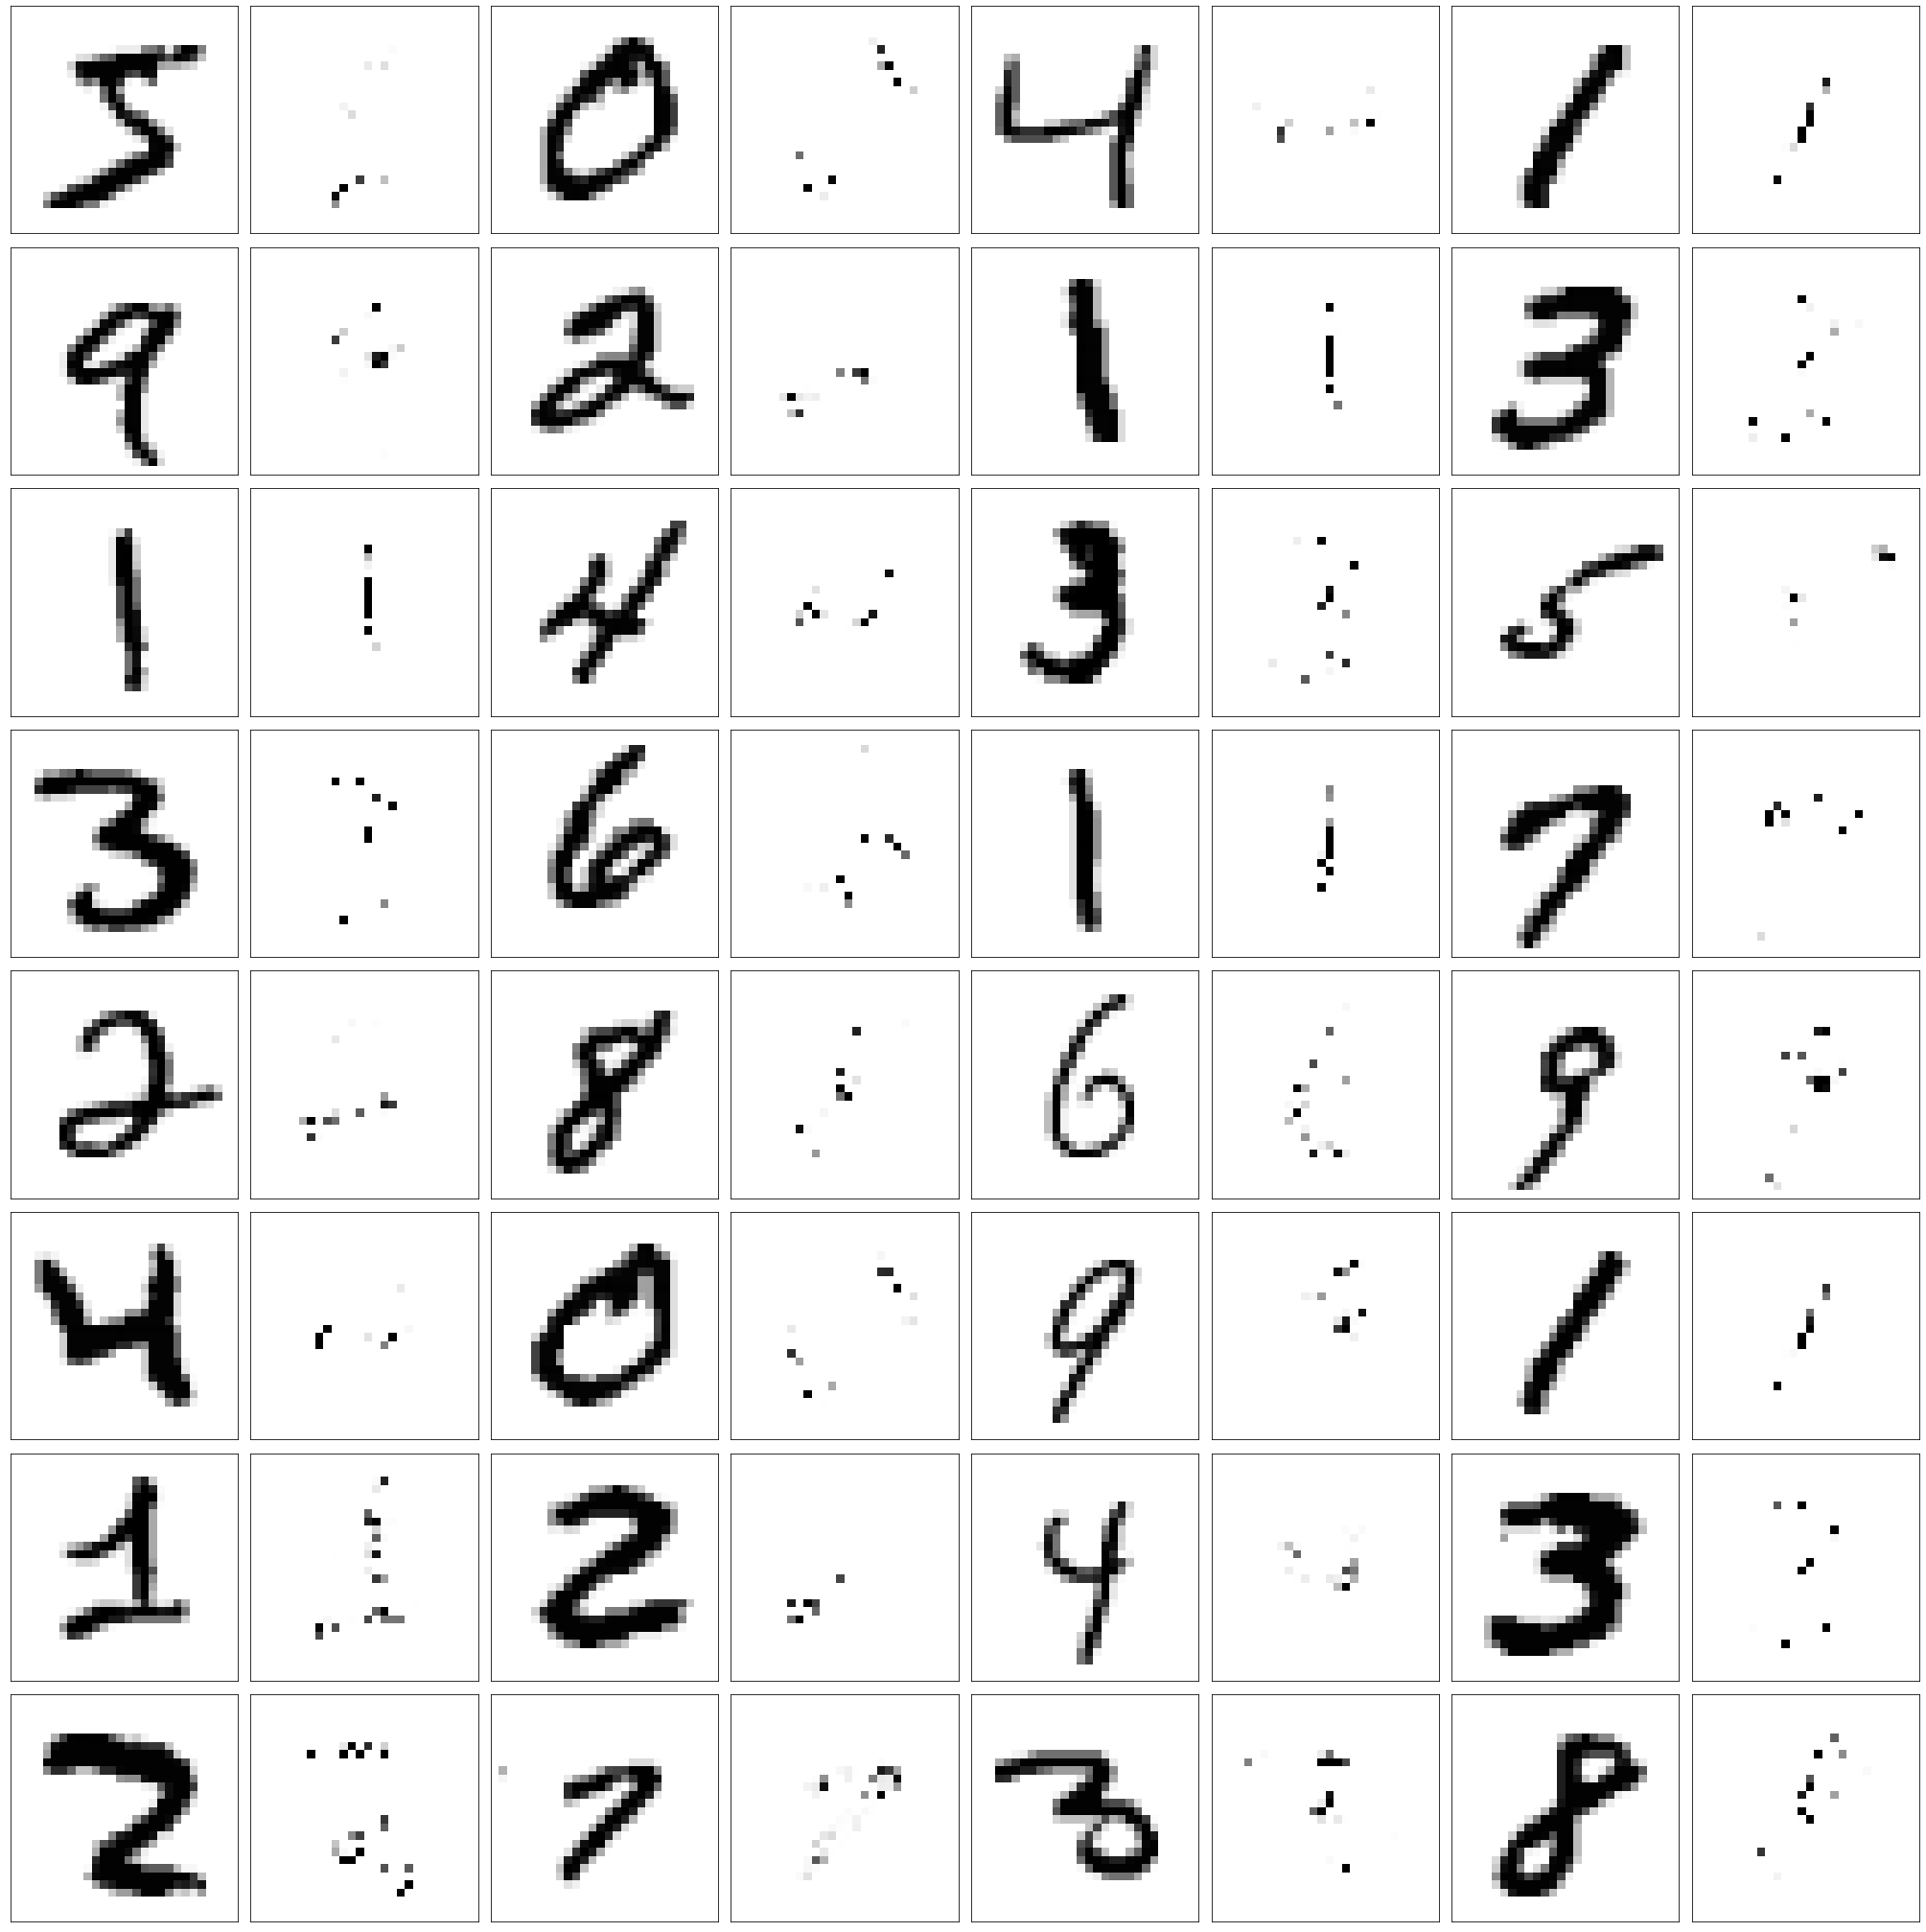

In [27]:
masked_img = modelexplainer.predict(x_train)
img = x_train
def plot_image(img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(1-img.reshape((28,28)), cmap='gray')
    
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(7*num_cols, 7*num_rows))
for i in range(num_images):
    plt.subplot(2*num_rows, 2*num_cols, 2*i+1)
    plot_image(img[i])
    plt.subplot(2*num_rows, 2*num_cols, 2*i+2)
    plot_image(masked_img[i])
plt.tight_layout()
plt.show()

In [28]:
def saliency(inputs):
    inps = tf.Variable(inputs)
    with tf.GradientTape() as tape:
        prediction = model(inps)
    return tape.gradient(prediction,inps)

In [29]:
saliency(x_train[:3]).shape

TensorShape([3, 784])

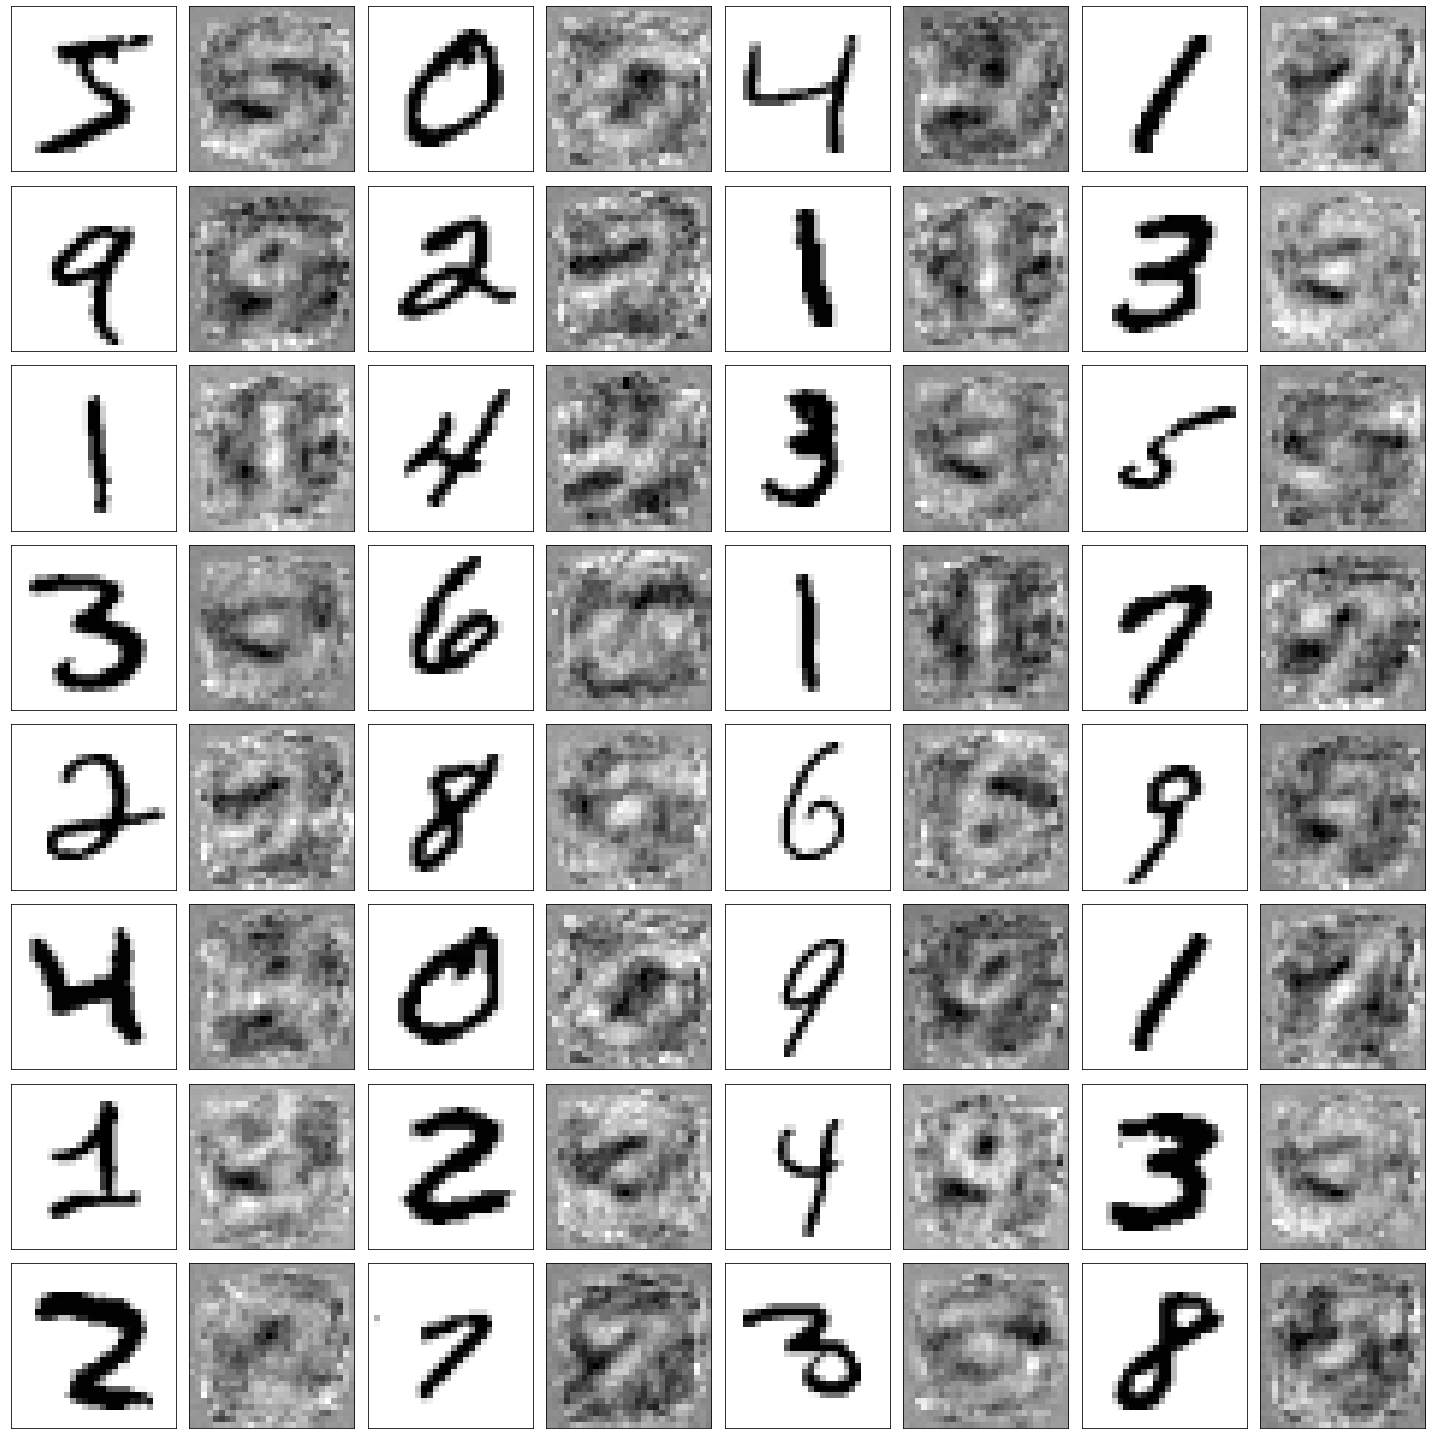

In [34]:
saliency_img = saliency(x_train).numpy()
img = x_train

num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(5*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(2*num_rows, 2*num_cols, 2*i+1)
    plot_image(img[i])
    plt.subplot(2*num_rows, 2*num_cols, 2*i+2)
    plot_image(saliency_img[i])#/np.max(saliency_img[i]))
plt.tight_layout()
plt.show()

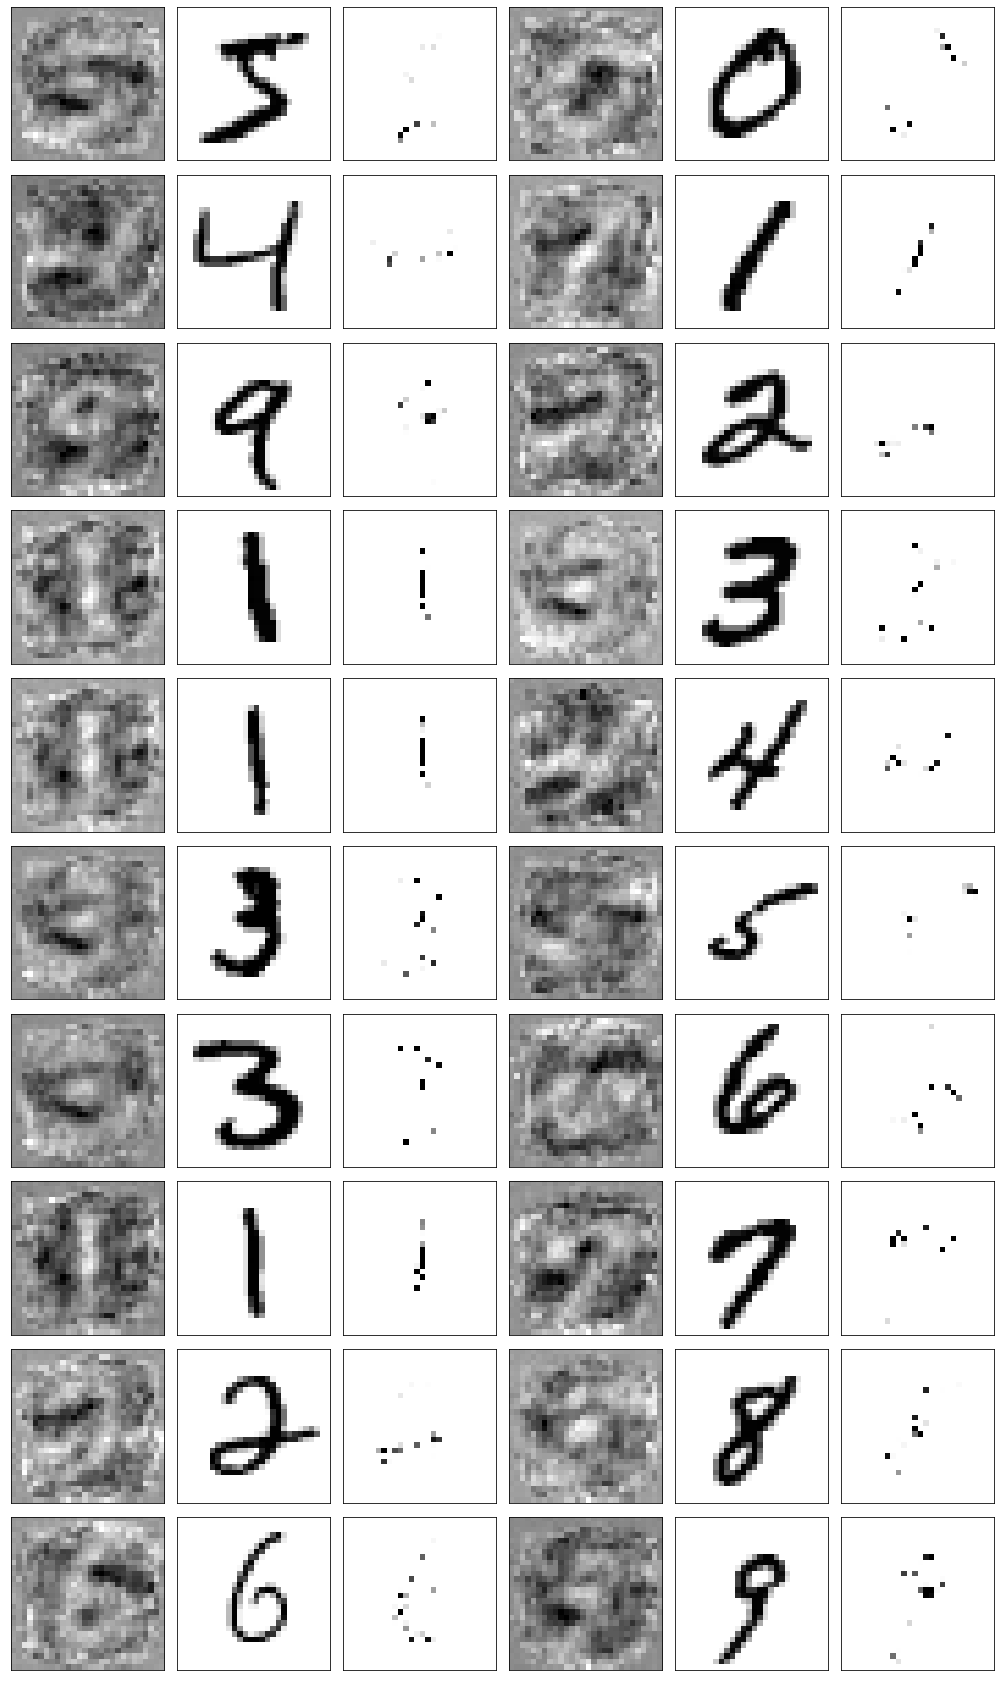

In [36]:
num_rows = 10
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(7*num_cols, 7*num_rows))
for i in range(num_images):
    plt.subplot(3*num_rows, 3*num_cols, 3*i+1)
    plot_image(saliency_img[i])
    plt.subplot(3*num_rows, 3*num_cols, 3*i+2)
    plot_image(img[i])
    plt.subplot(3*num_rows, 3*num_cols, 3*i+3)
    plot_image(masked_img[i])
plt.tight_layout()
plt.show()